In [1]:
from __future__ import division, print_function, absolute_import
from tqdm import tqdm

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import Image
import sys
from tensorflow.python.ops import control_flow_ops
sys.path.append('/home/ajss/notebooks/deep-learning-projects/')
from utils import tile_raster_images
import IPython.display

%matplotlib inline


In [2]:
def next_batch(index,data,labels,batch_size=10):
    """Return the next `batch_size` examples from this data set."""
    total = data.shape[0]
    end = index + batch_size
    max_end =  max(0, index + batch_size - total)
    retData =  np.concatenate((data[index:end],data[:max_end]), axis=0)
    retlabel =  np.concatenate((labels[index:end],labels[:max_end]), axis=0)
    return retData,retlabel

In [3]:
def plot_gallery(title, images, n_col, n_row,image_shape = (28, 28)):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,            
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)
    plt.show()   

In [4]:
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

# read training data from CSV file 
dataTrain = pd.read_csv('./kaggle-mnist/train.csv')
images = dataTrain.iloc[:,1:].values
images = images.astype(np.float)
images = np.multiply(images, 1.0 / 255.0) > 0.5

labels_flat = dataTrain[[0]].values.ravel()
labels_count = np.unique(labels_flat).shape[0]
labels = dense_to_one_hot(labels_flat, labels_count)
labels = labels.astype(np.uint8)

In [5]:
images.shape

(42000, 784)

In [6]:
labels.shape

(42000, 10)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.


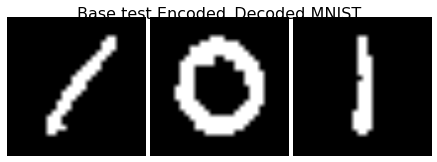

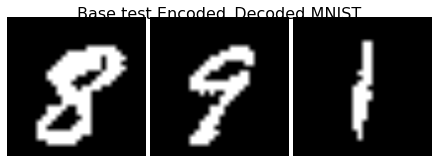

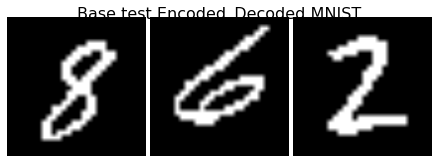

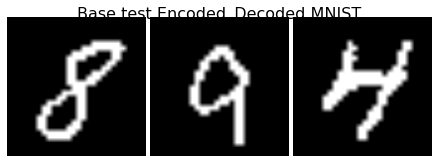

In [7]:
for i in range(4):
    batch_xs, batch_ys = next_batch(i*10, images,labels)
    plot_gallery('Base test Encoded_Decoded MNIST',batch_xs[:3],3,1)


In [8]:
# read test data from CSV file 
datatest = pd.read_csv('./kaggle-mnist/test.csv')
imagestest = datatest.iloc[:,:].values
imagestest = imagestest.astype(np.float)
imagestest = np.multiply(imagestest, 1.0 / 255.0)


In [9]:
imagestest.shape

(28000, 784)

RBM
---------

In [10]:
# size_x is the size of the visiable layer
# size_h is the size of the hidden layer
side_h = 10
size_x = 28*28
size_h = side_h * side_h
size_bt = 50 # batch size

k = tf.constant(1)


In [11]:


# helper function

def sample(probs):
    return tf.to_float(tf.floor(probs + tf.random_uniform(tf.shape(probs), 0, 1)))

def sampleInt(probs):
    return tf.floor(probs + tf.random_uniform(tf.shape(probs), 0, 1))



In [12]:
# variables and place holder

b = tf.Variable(tf.random_uniform([size_h, 1], -0.005, 0.005))
W = tf.Variable(tf.random_uniform([size_x, size_h], -0.005, 0.005))
c = tf.Variable(tf.random_uniform([size_x, 1], -0.005, 0.005))
x = tf.placeholder(tf.float32, [size_x, size_bt])
a = tf.placeholder(tf.float32)

In [13]:

# define graph/algorithm

# sample h x1 h1 ..
h = sample(tf.sigmoid(tf.matmul(tf.transpose(W), x) + tf.tile(b, [1, size_bt])))

# CD-k 
# we use tf.while_loop to achieve the multiple (k - 1) gibbs sampling  

# set up tf.while_loop()

def rbmGibbs(xx, hh, count, k):
    xk = sampleInt(tf.sigmoid(tf.matmul(W, hh) + tf.tile(c, [1, size_bt])))
    hk = sampleInt(tf.sigmoid(tf.matmul(tf.transpose(W), xk) + tf.tile(b, [1, size_bt])))
    # assh_in1 = h_in.assign(hk)
    return xk, hk, count+1, k

def lessThanK(xk, hk, count, k):
    return count <= k

ct = tf.constant(1)

[xk1, hk1, _, _] = control_flow_ops.While(lessThanK, rbmGibbs, [x, h, ct, k], 1, False)


In [14]:

# update rule
[W_, b_, c_] = [tf.mul(a/float(size_bt), tf.sub(tf.matmul(x, tf.transpose(h)), tf.matmul(xk1, tf.transpose(hk1)))),\
        tf.mul(a/float(size_bt), tf.reduce_sum(tf.sub(h, hk1), 1, True)),\
        tf.mul(a/float(size_bt), tf.reduce_sum(tf.sub(x, xk1), 1, True))]

# wrap session
updt = [W.assign_add(W_), b.assign_add(b_), c.assign_add(c_)]


In [15]:
# tr_x, tr_y  =  tf.train.shuffle_batch(
#       [images, labels], batch_size=100,
#       capacity=50000,
#       min_after_dequeue=10000)
# tr_y

In [19]:

# run session

sess = tf.Session()
init = tf.initialize_all_variables()
sess.run(init)

batch_size =30
interactions = int(math.floor(images.shape[0]/batch_size))
# loop with batch
for i in tqdm(range(1,21)):
    for j in range(interactions):
        tr_x, tr_y  = next_batch(j*batch_size,images,labels,batch_size)
        tr_x = np.transpose(tr_x)
        tr_y = np.transpose(tr_y)
        alpha = min(0.05, 100/float(i))
        sess.run(updt, feed_dict={x: tr_x, a: alpha})
    #     vidualization
        if i % 500 == 1:
            print(i, ' step size ', alpha)
            print('W.T')
            plt.figure()
            print(sess.run(W).T.shape)
            image = Image.fromarray(tile_raster_images(sess.run(W).T,
                                                       img_shape=(28, 28),
                                                       tile_shape=(side_h, side_h),
                                                       tile_spacing=(2, 2)))
            plt.imshow(image)
    #         print( 'c ', sess.run(c).T)
    #         print( 'b ', sess.run(b).T)
    #         print( 'W ', sess.run(W).T)
    #         print( 'x ', np.transpose(tr_x))
    #         print( 'h ', sess.run(h, feed_dict={x: tr_x}).T)
            # print 'x1 ', sess.run(x1, feed_dict={x: tr_x}).T
            # print 'h1 ', sess.run(h1, feed_dict={x: tr_x}).T  
            plt.figure()
            print('tr_x.T')
            print(np.transpose(tr_x).shape)
            imagex = Image.fromarray(tile_raster_images(np.transpose(tr_x),
                                                       img_shape=(28, 28),
                                                       tile_shape=(5, 10),
                                                       tile_spacing=(2, 2)))
    #         imagex.show()
            plt.imshow(imagex)
    #         fmt='png'
    #         f = StringIO()
    #         PIL.Image.fromarray(tile_raster_images(np.transpose(tr_x),
    #                                                    img_shape=(28, 28),
    #                                                    tile_shape=(10, 10),
    #                                                    tile_spacing=(2, 2))).save(f, fmt)
    #         IPython.display.display(IPython.display.Image(data=f.getvalue()))
            plt.figure()
            print('xk1.T')
            print(sess.run(xk1, feed_dict={x: tr_x}).T.shape)

            imagexk = Image.fromarray(tile_raster_images(sess.run(xk1, feed_dict={x: tr_x}).T,
                                                       img_shape=(28, 28),
                                                       tile_shape=(5, 10),
                                                       tile_spacing=(2, 2)))
    #         imagexk.show()
            plt.imshow(imagexk)

    #         PIL.Image.fromarray(a).save(f, fmt)
    #         IPython.display.display(IPython.display.Image(data=f.getvalue()))


ResourceExhaustedError: OOM when allocating tensor with shape[784,100]
	 [[Node: random_uniform_1/mul = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"](random_uniform_1/RandomUniform, random_uniform_1/sub)]]
Caused by op u'random_uniform_1/mul', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/usr/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/usr/lib/python2.7/dist-packages/tornado/ioloop.py", line 866, in start
    handler_func(fd_obj, events)
  File "/usr/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py", line 498, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-8e66c7a3dbdd>", line 4, in <module>
    W = tf.Variable(tf.random_uniform([size_x, size_h], -0.005, 0.005))
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/random_ops.py", line 250, in random_uniform
    return math_ops.add(rnd * (maxval - minval), minval, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/math_ops.py", line 754, in binary_op_wrapper
    return func(x, y, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/math_ops.py", line 903, in _mul_dispatch
    return gen_math_ops.mul(x, y, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_math_ops.py", line 1427, in mul
    result = _op_def_lib.apply_op("Mul", x=x, y=y, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 703, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2310, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1232, in __init__
    self._traceback = _extract_stack()
